In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('../data/cleaned/full.csv', index_col=0)

In [4]:
df = df.rename(columns={'sentiment_y' : 'sentiment'})

In [5]:
target = 'Adj Close'
features = ['Open', 'High', 'Low', 'Close', 'Volume']

In [6]:
runs = [
    ('No Sentiment', []),
    ('GPT3.5 Sentiment', ['s_score', 'a_score']),
    ('Finbert Sentiment',  ['sentiment'])
]

In [7]:
num_epochs = 50

In [8]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, num_features, hidden_layer_size, output_size):
        super(RNNModel, self).__init__()
        self.num_features = num_features
        self.hidden_layer_size = hidden_layer_size

        # Define the RNN layer
        self.rnn = nn.RNN(input_size=num_features, hidden_size=hidden_layer_size, batch_first=True)

        # Linear layer for output prediction
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Forward pass through RNN layer
        rnn_out, _ = self.rnn(input_seq)

        # Take the last hidden state for prediction
        last_hidden_state = rnn_out[:, -1, :]

        # Pass the last hidden state to the linear layer
        y_pred = self.linear(last_hidden_state)

        return y_pred


In [9]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, num_features, hidden_layer_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.num_features = num_features
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # The RNN takes feature sequences as inputs and outputs hidden states
        # with dimensionality hidden_layer_size.
        self.rnn = nn.RNN(input_size=num_features,
                          hidden_size=hidden_layer_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        # The linear layer that maps from hidden state space to output space
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Forward pass through RNN layer
        # shapes (batch, seq_len, num_features)
        rnn_out, _ = self.rnn(input_seq)

        # Only take the output from the final timestep
        # Here we use rnn_out[:, -1, :] just for the last time step
        last_time_step = rnn_out[:, -1, :]

        # Pass the last time step output to a Linear layer with 'output_size' units
        y_pred = self.linear(last_time_step)
        return y_pred

In [10]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.num_features = num_features
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        
        # The LSTM takes feature sequences as inputs and outputs hidden states
        # with dimensionality hidden_layer_size.
        self.lstm = nn.LSTM(input_size=num_features,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        # The linear layer that maps from hidden state space to output space
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Forward pass through LSTM layer
        # shapes (batch, seq_len, num_features)
        lstm_out, _ = self.lstm(input_seq)
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        # Here we use lstm_out[:, -1, :] just for the last time step
        last_time_step = lstm_out[:, -1, :]
        
        # Pass the last time step output to a Linear layer with 'output_size' units
        y_pred = self.linear(last_time_step)
        return y_pred

In [11]:
outputs = {}

In [12]:
outputs['lstm'] = {
        'actuals': [],
        'predicted': [],
        'losses': []
}

In [14]:
for i, (name, extra_features) in enumerate(runs):
    print(f'Starting run : {name}')
    y_ = df[target].values
    X1_ = df[features + extra_features].values
    feature_scaler1 = MinMaxScaler(feature_range=(0, 1))
    X1 = feature_scaler1.fit_transform(X1_)
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    y = target_scaler.fit_transform(y_.reshape(-1, 1))

    def create_sequences(features, target, time_steps):
        X1s, ys = [], []
        for i in range(len(features) - time_steps):
            X1s.append(features[i:(i + time_steps)])
            ys.append(target[i + time_steps])
        return np.array(X1s), np.array(ys)

    X1, y = create_sequences(X1, y, 5)

    X1_tensor = torch.tensor(X1, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    inds = np.arange(X1_tensor.shape[0])
    test_size = 0.5
    split_ind = int(inds.shape[0] * test_size)
    
    X1_test = X1_tensor[inds[:split_ind]]
    X1_train = X1_tensor[inds[split_ind:]]
        
    y_test = y_tensor[inds[:split_ind]]
    y_train = y_tensor[inds[split_ind:]]

    batch_size = 4
    train_data1 = torch.utils.data.TensorDataset(X1_train, y_train)
    train_loader1 = torch.utils.data.DataLoader(train_data1, shuffle=False, batch_size=batch_size)
    
    test_data1 = torch.utils.data.TensorDataset(X1_test, y_test)
    test_loader1 = torch.utils.data.DataLoader(test_data1, shuffle=False, batch_size=1)

    num_features = 5 + len(extra_features)
    hidden_layer_size = 50  # Number of features in hidden state
    output_size = 1  # Predicting 'Adj Close'
    num_layers = 2  # Number of recurrent layers
    
    model = LSTMModel(num_features, hidden_layer_size, output_size, num_layers)
    
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()  # Set the model to training mode

    train_losses = []
    print(f'Starting training')
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader1:
            optimizer.zero_grad()  # Clear the gradients
            y_pred = model(X_batch)  # Forward pass: compute the output
            loss = loss_function(y_pred, y_batch)  # Compute the loss
            loss.backward()  # Backward pass: compute the gradient
            optimizer.step()  # Update the weights
            running_loss += loss.item() * X_batch.size(0)  # Multiply by batch size
        epoch_loss = running_loss / len(train_loader1.dataset)
        train_losses.append(epoch_loss)
    # Set the model to evaluation mode
    model.eval()
    
    # To track the actuals and predictions
    actuals = []
    predictions = []
    
    with torch.no_grad():  # No need to track the gradients
        for X_batch, y_batch in test_loader1:
            # Forward pass: compute predicted y by passing X to the model.
            y_test_pred = model(X_batch)
            
            # Store predictions and actuals for later analysis
            actuals.extend(y_batch.numpy())
            predictions.extend(y_test_pred.numpy())
    
    # Convert lists to numpy arrays
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    
    # Inverse transform the predictions and actuals
    actuals_scaled_back = target_scaler.inverse_transform(actuals)
    predictions_scaled_back = target_scaler.inverse_transform(predictions)

    outputs['lstm']['actuals'].append(actuals_scaled_back)
    outputs['lstm']['predicted'].append(predictions_scaled_back)
    outputs['lstm']['losses'].append(train_losses)

Starting run : No Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

Starting run : GPT3.5 Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

Starting run : Finbert Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
outputs['rnn'] = {
        'actuals': [],
        'predicted': [],
        'losses': []
}

In [16]:
for i, (name, extra_features) in enumerate(runs):
    print(f'Starting run : {name}')
    y_ = df[target].values
    X1_ = df[features + extra_features].values
    feature_scaler1 = MinMaxScaler(feature_range=(0, 1))
    X1 = feature_scaler1.fit_transform(X1_)
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    y = target_scaler.fit_transform(y_.reshape(-1, 1))

    def create_sequences(features, target, time_steps):
        X1s, ys = [], []
        for i in range(len(features) - time_steps):
            X1s.append(features[i:(i + time_steps)])
            ys.append(target[i + time_steps])
        return np.array(X1s), np.array(ys)

    X1, y = create_sequences(X1, y, 5)

    X1_tensor = torch.tensor(X1, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    inds = np.arange(X1_tensor.shape[0])
    test_size = 0.5
    split_ind = int(inds.shape[0] * test_size)
    
    X1_test = X1_tensor[inds[:split_ind]]
    X1_train = X1_tensor[inds[split_ind:]]
        
    y_test = y_tensor[inds[:split_ind]]
    y_train = y_tensor[inds[split_ind:]]

    batch_size = 4
    train_data1 = torch.utils.data.TensorDataset(X1_train, y_train)
    train_loader1 = torch.utils.data.DataLoader(train_data1, shuffle=False, batch_size=batch_size)
    
    test_data1 = torch.utils.data.TensorDataset(X1_test, y_test)
    test_loader1 = torch.utils.data.DataLoader(test_data1, shuffle=False, batch_size=1)

    num_features = 5 + len(extra_features)
    hidden_layer_size = 50  # Number of features in hidden state
    output_size = 1  # Predicting 'Adj Close'
    num_layers = 2
    
    model = RNNModel(num_features, hidden_layer_size, output_size, num_layers)
    
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()  # Set the model to training mode

    train_losses = []
    print(f'Starting training')
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader1:
            optimizer.zero_grad()  # Clear the gradients
            y_pred = model(X_batch)  # Forward pass: compute the output
            loss = loss_function(y_pred, y_batch)  # Compute the loss
            loss.backward()  # Backward pass: compute the gradient
            optimizer.step()  # Update the weights
            running_loss += loss.item() * X_batch.size(0)  # Multiply by batch size
        epoch_loss = running_loss / len(train_loader1.dataset)
        train_losses.append(epoch_loss)
    # Set the model to evaluation mode
    model.eval()
    
    # To track the actuals and predictions
    actuals = []
    predictions = []
    
    with torch.no_grad():  # No need to track the gradients
        for X_batch, y_batch in test_loader1:
            # Forward pass: compute predicted y by passing X to the model.
            y_test_pred = model(X_batch)
            
            # Store predictions and actuals for later analysis
            actuals.extend(y_batch.numpy())
            predictions.extend(y_test_pred.numpy())
    
    # Convert lists to numpy arrays
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    
    # Inverse transform the predictions and actuals
    actuals_scaled_back = target_scaler.inverse_transform(actuals)
    predictions_scaled_back = target_scaler.inverse_transform(predictions)

    outputs['rnn']['actuals'].append(actuals_scaled_back)
    outputs['rnn']['predicted'].append(predictions_scaled_back)
    outputs['rnn']['losses'].append(train_losses)

Starting run : No Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

Starting run : GPT3.5 Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

Starting run : Finbert Sentiment
Starting training


  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
nets = ['rnn', 'lstm']
for n in nets:
    for i in range(3):
        print((np.abs(outputs[n]['actuals'][i] - outputs[n]['predicted'][i]) / outputs[n]['actuals'][i]).mean())


0.029508956
0.028350974
0.027281402
0.02686389
0.02899261
0.029301235


In [26]:
a.mean()

0.029301235

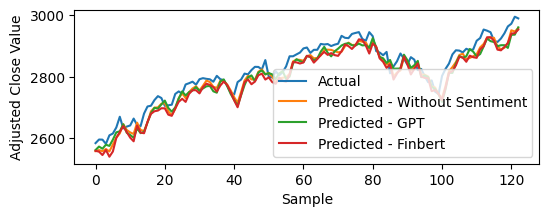

In [76]:
# Plotting
plt.figure(figsize=(6, 2))
plt.plot(actuals_[0], label='Actual')
plt.plot(outputs['rnn']['predicted'][0] - 100, label='Predicted - Without Sentiment')
plt.plot(outputs['rnn']['predicted'][1] - 100, label='Predicted - GPT')
plt.plot(outputs['rnn']['predicted'][2] - 100, label='Predicted - Finbert')

# plt.plot(predictions_scaled_back_2 - 100, label='Predicted - With Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.savefig('../imgs/RNN_pred.png')
plt.show()


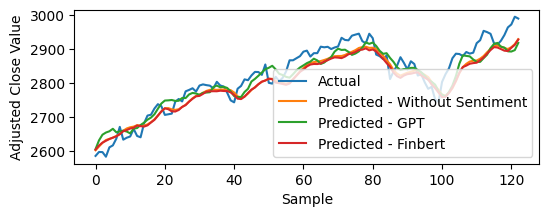

In [39]:
# Plotting
plt.figure(figsize=(6, 2))
plt.plot(actuals_[0], label='Actual')
plt.plot(predicted[0] - 100, label='Predicted - Without Sentiment')
plt.plot(predicted[1] - 100, label='Predicted - GPT')
plt.plot(predicted[2] - 100, label='Predicted - Finbert')

# plt.plot(predictions_scaled_back_2 - 100, label='Predicted - With Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.savefig('../imgs/LSTM_pred.png')
plt.show()


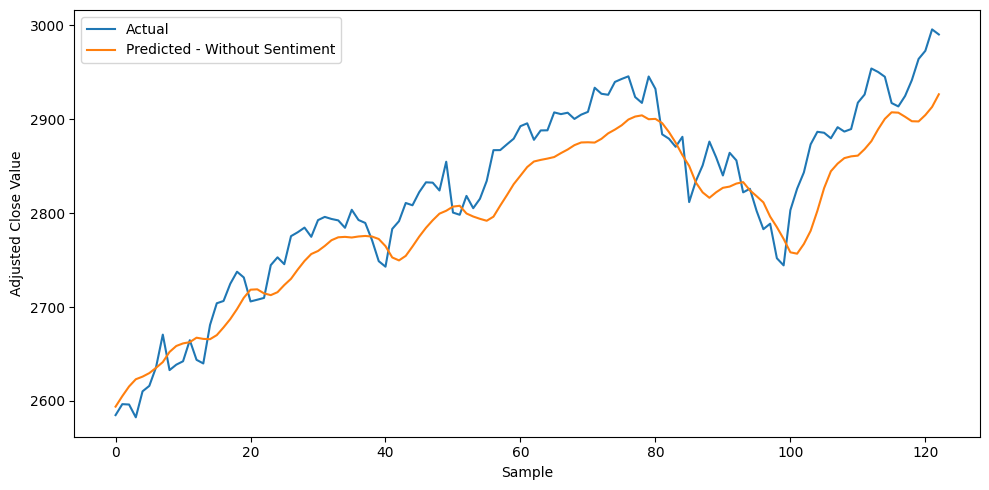

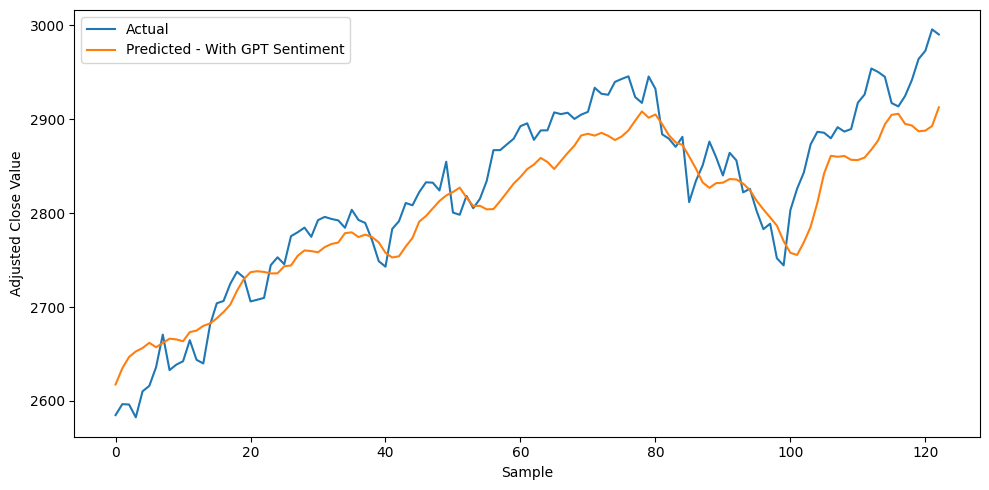

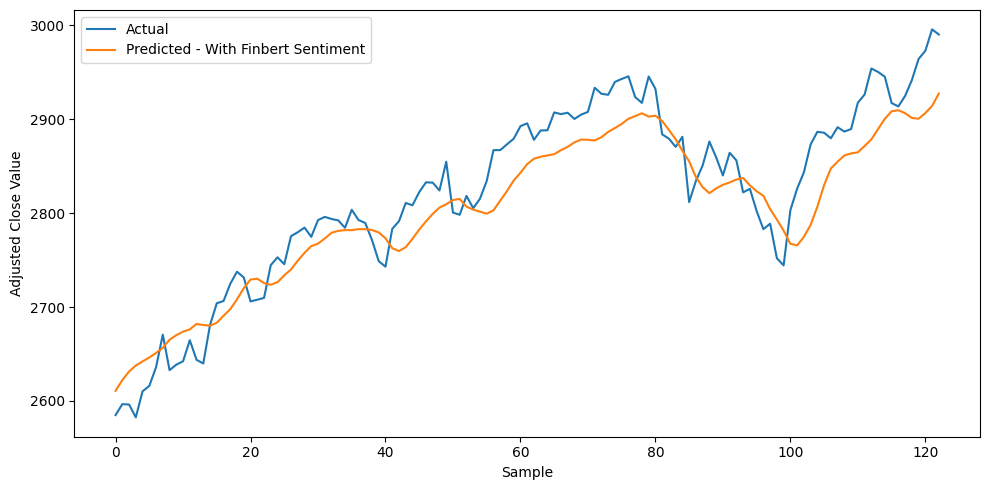

In [35]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 8))  # Adjust the figure size as needed

size = (10, 5)
# First subplot
# plt.subplot(3, 1, 1)
plt.figure(figsize=size)
plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['lstm']['predicted'][0] - 100, label='Predicted - Without Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()
plt.tight_layout()
plt.savefig('../imgs/predictions1.png')

# Second subplot
plt.figure(figsize=size)
plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['lstm']['predicted'][1] - 100, label='Predicted - With GPT Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.tight_layout()
plt.savefig('../imgs/predictions2.png')

# Third subplot
plt.figure(figsize=size)

plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['lstm']['predicted'][2] - 100, label='Predicted - With Finbert Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.savefig('../imgs/predictions3.png')
plt.show()


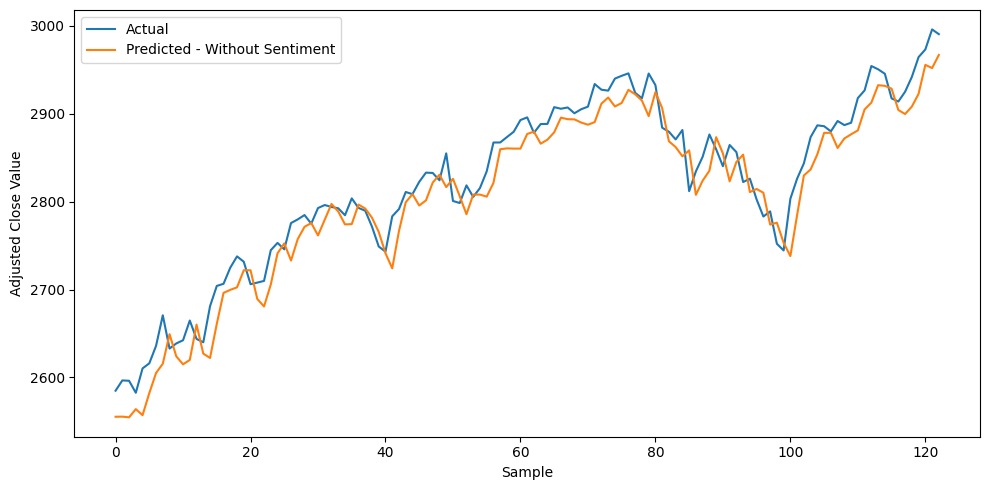

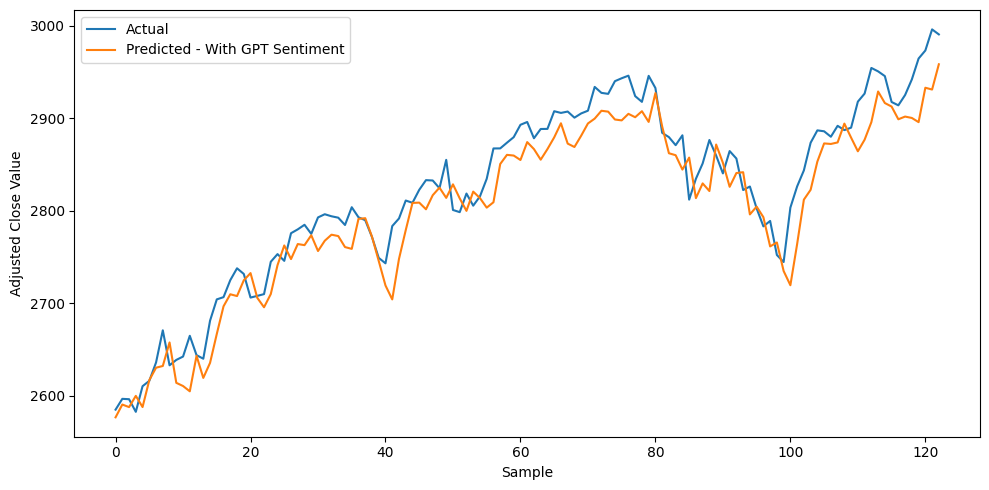

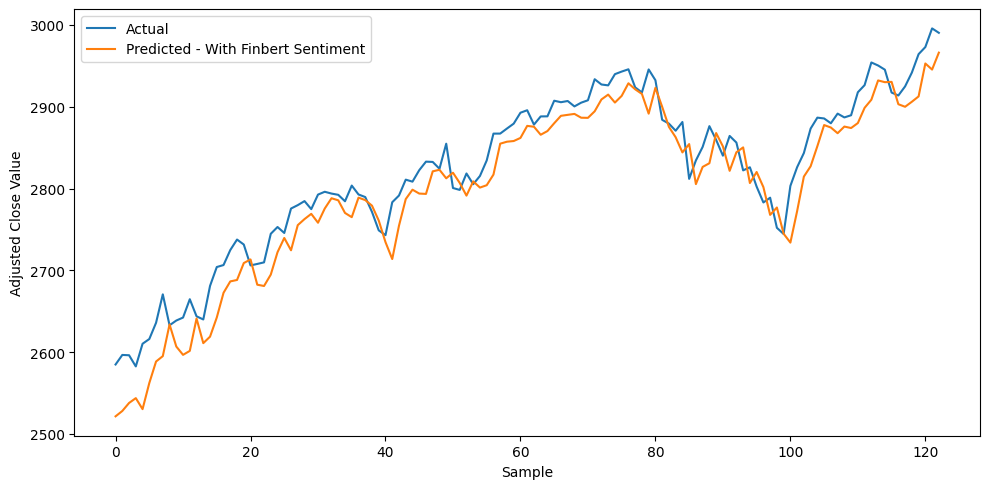

In [36]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 8))  # Adjust the figure size as needed

size = (10, 5)
# First subplot
# plt.subplot(3, 1, 1)
plt.figure(figsize=size)
plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['rnn']['predicted'][0] - 100, label='Predicted - Without Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()
plt.tight_layout()
plt.savefig('../imgs/predictions4.png')

# Second subplot
plt.figure(figsize=size)
plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['rnn']['predicted'][1] - 100, label='Predicted - With GPT Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.tight_layout()
plt.savefig('../imgs/predictions5.png')

# Third subplot
plt.figure(figsize=size)

plt.plot(outputs['rnn']['actuals'][0], label='Actual')
plt.plot(outputs['rnn']['predicted'][2] - 100, label='Predicted - With Finbert Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.savefig('../imgs/predictions6.png')
plt.show()


In [51]:
from pmdarima import auto_arima

# Assuming y is your preprocessed time series data
model = auto_arima(df.rename(columns={'Date_': 'Date'}).set_index('Date')['Adj Close'], start_p=1, start_q=1,
                   test='adf',       # Use adf test to find optimal 'd'
                   max_p=3, max_q=3, # Maximum p and q
                   m=1,              # Frequency of series
                   d=None,           # Let model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2276.035, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2274.892, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2275.104, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2274.857, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2277.018, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2275.999, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2277.993, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2277.864, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.508 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1134.429
Date:                Tue, 05 Dec 2023   AIC                           2274.857
Time:                        09:50:2

In [71]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming y_ is your target variable and it's already loaded as in your code
y = df[target].values
# target_scaler = MinMaxScaler(feature_range=(0, 1))
# y = target_scaler.fit_transform(y_.reshape(-1, 1)).squeeze()  # ARIMA works on 1D array

# Split data into train and test
test_size = int(len(y) * 0.5)
train, test = y[:test_size], y[test_size:]

# Fit ARIMA model (example parameters: p=5, d=1, q=0)
model = ARIMA(train, order=(4, 4, 4))
model_fit = model.fit()

# Forecast
predictions = model_fit.forecast(steps=len(test))

# Evaluate forecasts
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# Plot or analyze the predictions and actuals as needed


/home/wsanf/code/dl_proj/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MSE: 188712229.855


/home/wsanf/code/dl_proj/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
